In [2]:
using OptimalControl

In [7]:
tf = 1.0
t0 = 0.0
x0 = [1,0]
bc = [1.0, 0.0]  # Boundary conditions for x
function F0(x)
    x1, x2 = x
    return [ 0, -x2 ]
end
function F1(x)
    x1, x2 = x
    return [10*x2 - x1  , x1 - 9*x2]
end

@def ocp begin
    # variables
    t ∈ [ t0, tf ]  , time
    x ∈ R²          , state
    u ∈ R           , control

    # constraints
    0 ≤ u(t) ≤ 1,           (u_con)
    x(t0) == [1,0],         (initial_con)
    # dynamics
    ẋ(t) == F0(x(t)) + u(t)*F1(x(t))
    # objective
    -1.0 + x₁(tf) + x₂(tf) → min
end



The (autonomous) optimal control problem is given by:

    t ∈ [t0, tf], time
    x ∈ R², state
    u ∈ R, control
    0 ≤ u(t) ≤ 1, u_con
    x(t0) == [1, 0], initial_con
    ẋ(t) == F0(x(t)) + u(t) * F1(x(t))
    -1.0 + x₁(tf) + x₂(tf) → min

The (autonomous) optimal control problem is of the form:

    minimize  J(x, u) = g(x(0.0), x(1.0))

    subject to

        ẋ(t) = f(x(t), u(t)), t in [0.0, 1.0] a.e.,

        ηl ≤ η(x(t)) ≤ ηu, 
        ϕl ≤ ϕ(x(0.0), x(1.0)) ≤ ϕu, 

    where x(t) ∈ R² and u(t) ∈ R.

Declarations (* required):



┌────────┬────────┬──────────┬──────────┬───────────┬────────────┬─────────────┐
│ times* │ state* │ control* │ variable │ dynamics* │ objective* │ constraints │
├────────┼────────┼──────────┼──────────┼───────────┼────────────┼─────────────┤
│     ✅ │     ✅ │       ✅ │       ❌ │        ✅ │         ✅ │          ✅ │
└────────┴────────┴──────────┴──────────┴───────────┴────────────┴─────────────┘


In [8]:
# solve the optimal control problem without initial guess
sol = solve(ocp, display=true)

# print the number of iterations
println("Number of iterations: ", sol.iterations)

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     1202
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      202

Total number of variables............................:      303
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      101
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -8.0000000e-01 9.00e-01 3.29e-03   0.

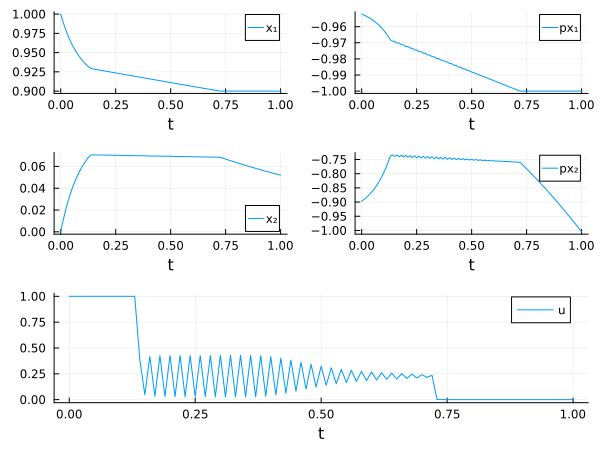

In [9]:
plot(sol, size=(600, 450))

In [29]:
u0 = 0
u1 = 1
H0 = Lift(F0)
H1 = Lift(F1)
H01  = @Lie {H0, H1}
H001 = @Lie {H0, H01}
H101 = @Lie {H1, H01}
us(x, p) = -H001(x, p) / H101(x, p)

# boundary control
g(x)    = bc-x # g(x) ≥ 0
ub(x)   = -Lie(F0, g)(x) / Lie(F1, g)(x)
μ(x, p) = H01(x, p) / Lie(F1, g)(x)

# flows
f0 = Flow(ocp, (x, p) -> u0)
f1 = Flow(ocp, (x, p) -> u1)
fs = Flow(ocp, (x, p) -> us(x, p))
fb = Flow(ocp, (x, p) -> ub(x), (x, u) -> g(x), (x, p) -> μ(x, p))


# solution
p0 = [3.945764658668555, 0.15039559623198723]
t1 = 0.023509684041475312
t2 = 0.059737380900899015
t3 = 0.10157134842460895

f1sb0 = f1 * (t1, fs) * (t2, fb) * (t3, f0) # concatenation of the flows
flow_sol = f1sb0((t0, tf), x0, p0)
sol = CTFlows.OptimalControlSolution(flow_sol)

# add to the sol
sol.objective = flow_sol.ode_sol(tf)[1]
sol.message = "structure: Bang-Singular-Boundary-Zero"
sol.infos[:resolution] = :numerical
sol.infos[:initial_costate] = p0
sol.infos[:final_time] = tf
sol.infos[:switching_times] = [t1, t2, t3]

result = OptimalControlProblem("hi", ocp, sol)

DimensionMismatch: DimensionMismatch: gradient(f, x) expects that f(x) is a real number. Perhaps you meant jacobian(f, x)?